# TP2 : American options

In [20]:
Sval = 90

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib as mpl
import time
import scipy.stats as stats
import pandas as pd
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

mpl.rcParams['figure.dpi'] = 125

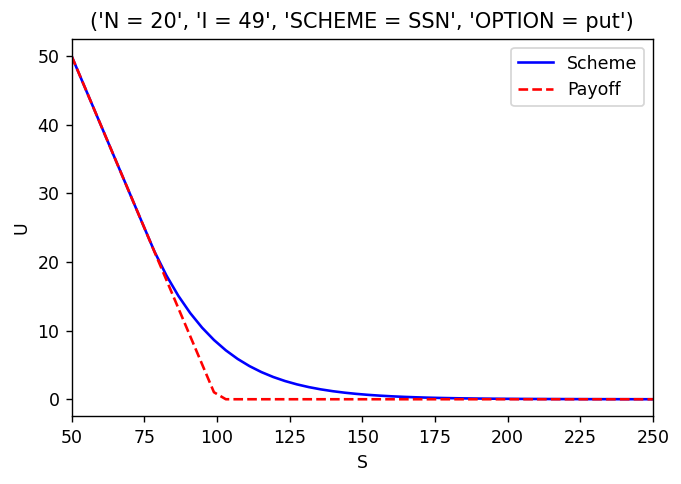

In [31]:
import numpy as np

class SchemePrice:
    def __init__(self, N, I, scheme = "EE", option = "put"):
        self.r = 0.1
        self.sigma = 0.3
        self.payoff = 1
        self.K = 100
        self.T = 1
        self.N = int(N)
        self.I = int(I)
        self.PSORit = 0
        self.SCHEME = scheme
        self.option = option
        self.Smin = 50
        self.Smax = 250
        self.h = (self.Smax - self.Smin) / self.I
        self.dt = self.T / self.N
        self.S = np.linspace(self.Smin,  self.Smax, self.I + 1)
        self.time = np.arange(0, self.T + self.dt, self.dt)
        self.A = self.createA()
        self.U = self.createU()
        self.B = np.identity(self.A.shape[0]) + self.dt * self.A
        self.U0 = self.u0(self.S)
        self.SCHEME = scheme
        self.title = 'N =%3i'%self.N,'I =%3i'%self.I,'SCHEME = %s'%self.SCHEME, 'OPTION = %s'%self.option
        self.mu = (self.dt/self.h**2)*self.sigma**2*self.Smax**2
        self.tcpu = 0
        self.solved = False
        
                            
    def plot(self):
        self.checkSolved()
        plt.plot(self.S, self.U, color='blue', label='Scheme')
        plt.plot(self.S, self.U0, linestyle="--", color='red', label='Payoff')
        plt.xlim([self.Smin, self.Smax])
        plt.title(self.title)
        plt.xlabel("S")
        plt.ylabel("U")
        plt.legend()
        plt.show()

    def checkSolved(self):
        if not self.solved:
            self.U = self.solve()
    
    def Ind(self, a, b, x):
        return np.where((a <= x) & (x <= b), 1, 0)

    def u0(self, s):
        """
        if self.option == "put":
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)
        elif self.option == "call":
            return np.maximum(0, s - self.K) * self.Ind(self.Smin, self.Smax, s)
        """
        if self.payoff == 1:
            return np.maximum(0, self.K - s) * self.Ind(self.Smin, self.Smax, s)

    def uleft(self, t):
        if self.payoff == 1:
            return self.K - self.Smin
        """
        if self.option == "put":
            return self.K * np.exp(-self.r * t) - self.Smin
        elif self.option == "call":
            return 0
        """

    def uright(self, t):
        if self.payoff == 1:
            return 0
        """
        if self.option == "put":
            return 0
        elif self.option == "call":
            return self.Smax - self.K * np.exp(-self.r * t)
        """

    def s(self, j):
        return self.Smin + j * self.h

    def alpha(self, j):
        return self.sigma**2 * self.s(j)**2 / (2 * self.h**2)

    def beta(self, j):
        return self.r * self.s(j) / (2 * self.h)
    
    def interpolate(self, s):
        self.checkSolved()
        s_index = np.argmax(self.S >= s)
        return ((self.S[s_index] - s)/self.h * self.U[s_index-1] + (s - self.S[s_index-1])/self.h * self.U[s_index])[0]

    def createA(self):
        A = np.zeros((self.I + 1, self.I + 1))
        for i in range(self.I + 1):
            alpha = self.alpha(i)
            beta = self.beta(i)
            A[i, i] = 2 * alpha + self.r
            if i > 0:
                A[i, i - 1] = -alpha + beta
            if i < self.I:
                A[i, i + 1] = -alpha - beta
        return A

    def q(self, t):
        y = np.zeros(self.I + 1)
        y[0] = (-self.alpha(0) + self.beta(0)) * self.uleft(t)
        y[-1] = (-self.alpha(self.I) + self.beta(self.I)) * self.uright(t)
        return y.reshape(self.I + 1, 1)

    def createU(self):
        U = self.u0(self.S)
        return U.reshape(self.I + 1, 1)
    
    def blackScholes(self, sbar):
        dplus=(np.log(sbar/self.K)+self.r+0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        dmoins=(np.log(sbar/self.K)+self.r-0.5*self.T*(self.sigma**2))/(self.sigma*np.sqrt(self.T))
        vbar=np.exp(-self.r*self.T)*self.K*stats.norm.cdf(-dmoins)-sbar*stats.norm.cdf(-dplus)
        return vbar
    
    
    def projected_UL_algorithm(self):
        g = self.U0
        x0 = g.copy()
        A = self.A
        dt = self.dt
        B = self.B
        U, L = uldecomp(B)

        x = x0.copy()

        for n in range(self.N):
            
            if n == 0:
                check_decomp(self.B)
            b = x - dt * self.q(self.time[n+1]).flatten()
            xold = x.copy()
            c = upwind(U, b)
            x = descente_p(L, c, g)
            if self.N - n <= 10:
                print(f'Check: |min(B x- b, x-g)|_inf= {np.linalg.norm(np.minimum(B @ x - b, x - g), np.inf)}')
            
        return x
    
    def solve(self):
        t0 = time.time()
        theta = 0.5 if self.SCHEME == "CR" else 0

        if self.payoff == 1:
            
            if self.SCHEME == 'EI-AMER-UL':
                self.U = self.projected_UL_algorithm()
            else:
            
            
                for n in range(self.N):
                    if self.SCHEME == "EE":
                        self.U = np.maximum(self.U - self.dt * (self.A @ self.U + self.q(self.time[n])), self.U0[:, np.newaxis])
                    elif self.SCHEME == "EI-AMER-SPLIT":
                        kmax = 1000
                        eta = 1e-6
                        """U1 = np.linalg.solve(np.identity(self.I + 1) + self.dt * self.A, -self.dt * self.q(self.time[n]) + self.U)
                        self.U = np.maximum(U1, self.U0[:, np.newaxis])"""
                        b = self.U - self.dt * self.q(self.time[n])  # Function q(t, I) for boundary/external conditions, needs to be defined
                        x = self.U0.copy()
                        xold = x.copy()
                        for k in range(kmax):
                            xold[:] = x
                            for i in range(self.I):
                                sum1 = np.dot(self.B[i, :i], x[:i])
                                sum2 = np.dot(self.B[i, i+1:], xold[i+1:])
                                x[i] = (b[i] - sum1 - sum2) / self.B[i, i]
                                x[i] = max(x[i], self.U0[i])  # Projection step
                            self.PSORit += 1
                            if np.linalg.norm(x - xold, np.inf) < eta:
                                break
                        self.U = x[:, np.newaxis]
                    elif self.SCHEME == "CR":
                        theta = 0.5
                        F = -(theta * self.q(self.time[n + 1]) + (1 - theta) * self.q(self.time[n]))
                        part1 = self.U - (1 - theta) * self.dt * (self.A @ self.U)
                        U1 = np.linalg.solve(np.identity(self.I + 1) + theta * self.dt * self.A, 
                                             self.U - theta*self.dt*(self.q(self.time[n])+ self.q(self.time[n+1])+ self.A@self.U))
                        self.U = np.maximum(U1, self.U0[:, np.newaxis])
                    elif self.SCHEME == "SSN":  # Semi-Smooth Newton's method as a new scheme
                        b = self.U[:, 0] - self.dt * self.q(self.time[n]).flatten()  # Ensure b is a vector
                        g = self.U0 # Ensure g is a vector
                        x0 = self.U.copy().flatten()  # Ensure x0 is a vector
                        x = newton(self.B, b, self.U, g, x0, kmax=1000, eta=1e-6)
                        self.U = x.reshape(self.U.shape)
        self.tcpu = time.time() - t0
        self.solved = True
        return self.U

    
def stabilityTable(scheme, s, Ns, Is, pricer = SchemePrice):

    Us = []
    tcpus = []
    errs = []
    ords = []
    U = 0

    for i in range(len(Ns)):
        N = Ns[i]
        I = Is[i]
        ee = pricer(N, I, scheme)
        newU = ee.interpolate(s)
        Us.append(newU)
        tcpus.append(ee.tcpu)
        
        if i == 0:
            errs.append(0)
            ords.append(0)
        elif i == 1:
            errs.append(np.abs(U - newU))
            ords.append(0)
        else:
            errs.append(np.abs(U - newU))
            ords.append(np.log(errs[i-1]/errs[i]) / np.log(2))
        
        U = newU

    df = pd.DataFrame({'I': Is, 'N': Ns, 'U(s)': Us})
    df['err'] = errs
    df['ords'] = ords
    df['tcpu'] = tcpus

    return df


SchemePrice(20, 49, "SSN").plot()


In [61]:
Is = np.array([19, 39, 79, 159, 319])
Ns = 2*np.array(Is + 1)**2/10

stabilityTable("EE", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,80.0,13.109335,0.000000,0.000000,0.000999
1,39,320.0,13.132719,0.023384,0.000000,0.003164
2,79,1280.0,13.122493,0.010226,1.193271,0.009508
3,159,5120.0,13.121559,0.000934,3.452266,0.476334
4,319,20480.0,13.120893,0.000666,0.488848,1.958799


## 2) A first implicit scheme: the splitting scheme

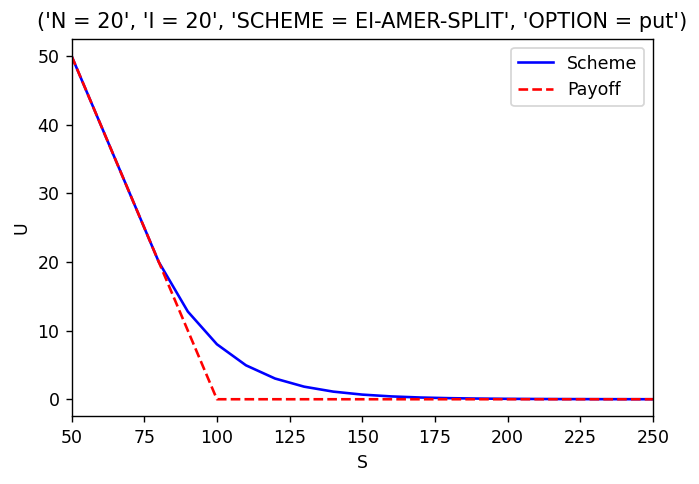

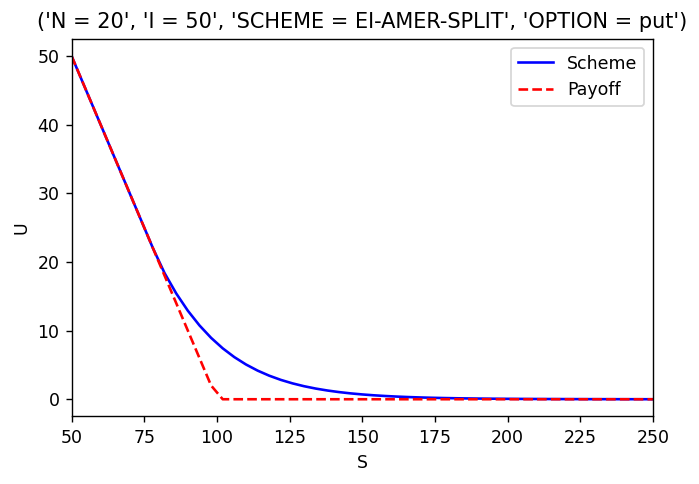

In [62]:

SchemePrice(20, 20, "EI-AMER-SPLIT").plot()
SchemePrice(20, 50, "EI-AMER-SPLIT").plot()

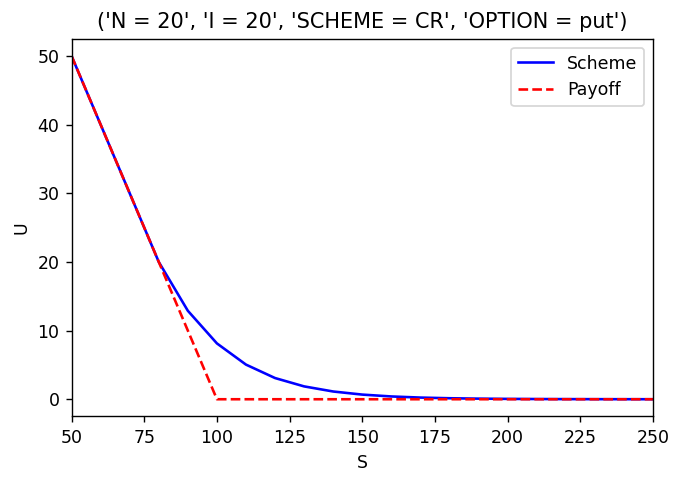

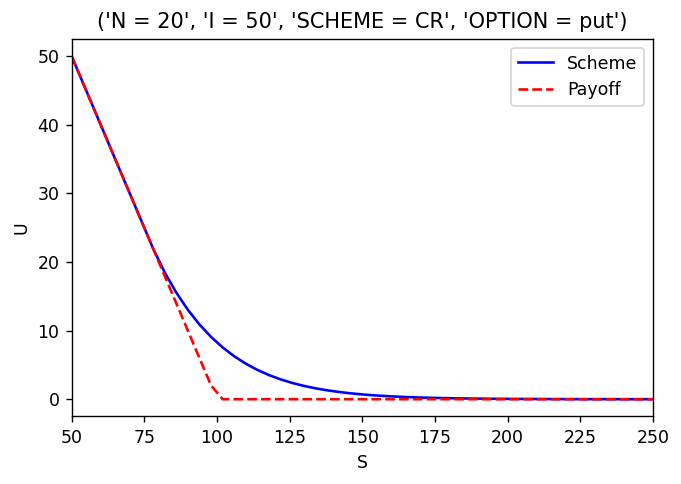

In [63]:

SchemePrice(20, 20, "CR").plot()
SchemePrice(20, 50, "CR").plot()

In [75]:
Is = 20*pow(2,(np.arange(1, 6, 1)))
Ns = Is - 1
stabilityTable("EI-AMER-SPLIT", 90, Ns, Is)


,I,N,U(s),err,ords,tcpu
0,40,39,12.956619,0.000000,0.000000,0.020888
1,80,79,13.054138,0.097520,0.000000,0.102748
2,160,159,13.089620,0.035482,1.458620,0.575214
3,320,319,13.105555,0.015935,1.154861,2.907120
4,640,639,13.113216,0.007660,1.056706,14.468546


In [76]:
Is = 20*pow(2,(np.arange(1, 6, 1)))
Ns = Is - 1
stabilityTable("CR", 90, Ns, Is)


,I,N,U(s),err,ords,tcpu
0,40,39,13.021034,0.000000,0.000000,0.018593
1,80,79,13.090751,0.069717,0.000000,0.132066
2,160,159,13.107748,0.016996,2.036299,0.714555
3,320,319,13.114964,0.007216,1.235940,2.967477


## 3) Implicit Euler Scheme


### 3.2) Semi-smooth Newton’s method

In [28]:
def F(B, b, x, g):
    return np.minimum(np.dot(B, x) - b, x - g)

def F_prime(B, b, x, g):  # Derivative of F
    condition = np.dot(B, x) - b <= x - g
    return np.where(condition[:, None], B, np.eye(len(B)))

def newton(B, b, x, g, x0, kmax=1000, eta=1e-6):
    x = x0.copy()
    for _ in range(kmax):
        xold = x.copy()
        x -= np.linalg.inv(F_prime(B, b, x, g)) @ F(B, b, x, g)
        if np.linalg.norm(x - xold) < eta:
            break
    return x

In [205]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("SSN", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.645642,0.000000,0.000000,0.001997
1,39,4.0,12.837617,0.191975,0.000000,0.011025
2,79,8.0,12.965506,0.127889,0.586030,0.394985
3,159,16.0,13.038332,0.072826,0.812367,1.170799
4,319,32.0,13.077743,0.039411,0.885852,8.226859


In [166]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("EI-AMER-SPLIT", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.645608,0.000000,0.000000,0.015000
1,39,4.0,12.837612,0.192003,0.000000,0.101000
2,79,8.0,12.965497,0.127885,0.586284,0.753000
3,159,16.0,13.038291,0.072794,0.812947,5.355999
4,319,32.0,13.077570,0.039279,0.890083,38.512010


In [167]:
Is = np.array([19, 39, 79, 159, 319])
Ns = np.array(Is + 1)/10

stabilityTable("CR", 90, Ns, Is)

,I,N,U(s),err,ords,tcpu
0,19,2.0,12.990264,0.000000,0.000000,0.000000
1,39,4.0,12.919502,0.070762,0.000000,0.009000
2,79,8.0,12.943399,0.023898,1.566105,0.173998
3,159,16.0,13.023492,0.080092,-1.744796,0.056000
4,319,32.0,13.075159,0.051667,0.632411,0.549000


norme de B-UL:  1.7763568394002505e-15
norme de B-UL:  1.7763568394002505e-15
Check: |min(B x- b, x-g)|_inf= 0.13974317870449582
Check: |min(B x- b, x-g)|_inf= 0.13688179790745636
Check: |min(B x- b, x-g)|_inf= 0.13434274853989336
Check: |min(B x- b, x-g)|_inf= 0.13186382962980758
Check: |min(B x- b, x-g)|_inf= 0.1294387153545884
Check: |min(B x- b, x-g)|_inf= 0.12708943388680893
Check: |min(B x- b, x-g)|_inf= 0.12482719514353136
Check: |min(B x- b, x-g)|_inf= 0.12265685830607609
Check: |min(B x- b, x-g)|_inf= 0.12083045293083927
Check: |min(B x- b, x-g)|_inf= 0.11933166501363246


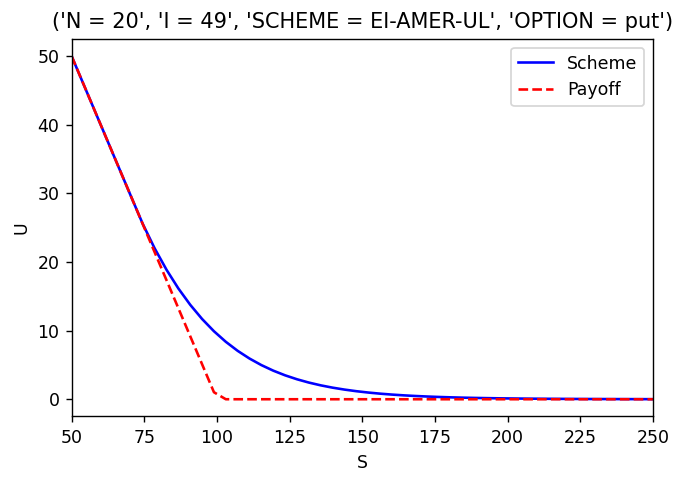

In [23]:
import scipy.linalg as slng
import numpy as np
import numpy.linalg as lng

def uldecomp(B):
    n = B.shape[0]
    U = B.copy()
    L = np.eye(n)  # Initialize L as an identity matrix

    for i in range(n):
        # Loop over rows below the diagonal for the current column i
        for j in range(i+1, n):
            # Calculate the multiplier for the row operations
            factor = U[j, i] / U[i, i]
            # Subtract the factor times the ith row from the jth row
            U[j, i:] = U[j, i:] - factor * U[i, i:]
            # Store the multiplier in the L matrix
            L[j, i] = factor

    return U, L

def check_decomp(B):
    U, L = uldecomp(B)
    print('norme de B-UL: ', lng.norm(B-L@U,np.inf));

def upwind(U, b):
    c = lng.solve(U,b)
    return c

def descente_p(L, c, g):
    x = np.zeros_like(c)
    for i in range(len(c)):
        x[i] = max((c[i] - L[i, :i] @ x[:i]) / L[i, i], g[i])
    return x


ee = SchemePrice(20, 49, 'EI-AMER-UL')
A = ee.A
dt = ee.dt
B = ee.B
check_decomp(B)

ee.plot()

